# Decision Trees
##### Sean Wade

In [417]:
from __future__ import division
import numpy as np
from collections import Counter
import math
from mltools.dataManager import DataManager
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

In [2]:
def entropy(p):
    if p == 0:
        return 0
    return p * math.log(p, 2)

In [3]:
def infoGain(data, labels, feature): 
    n, d = data.shape
    
    # Number of classes
    classes = np.unique(labels)
    
    # Values a feature can take
    unique_vals, counts = np.unique(data[:,feature], return_counts=True)
    
    total = 0
    for val, val_count in zip(unique_vals, counts):
        val_idx = np.where(data[:,feature] == val)[0]
        sub_data = data[val_idx]
        sub_label = labels[val_idx]
        
        probs = []
        class_cnts = Counter(sub_label)
        for cl in classes:
            total -= (val_count / n) * entropy(class_cnts[cl] / len(sub_label))
            probs.append(class_cnts[cl] / len(sub_label))
                
    probs = []
    class_cnts = Counter(labels)
    for cl in classes:
        probs.append(class_cnts[cl] / len(labels))
        
    return total

In [504]:
class DecisionNode:
    
    def __init__(self, parent=None):
        self.attribute = None
        self.parent = parent
        self.children = []
        self.purity = None
        self.on = True
        
    def __eq__(self, other):
        try:
            if self.attribute != other.attribute:
                return False
            if self.purity != other.purity:
                return False
            if self.parent != other.parent:
                return False
            if self.children != other.children:
                return False
            return True
        except:
            return False
    
    def __ne__(self, other):
        return not self.__eq__(other)
        
        
        
    def __repr__(self):
        to_string = ''
        to_string += "Split Attribute: %s\n" % str(self.attribute)
        to_string += "Print Purity: %s\n" % str(self.purity)
        if self.children != []:
            to_string += "Children: %s\n" % str([x.attribute for x in self.children])
        return to_string

In [515]:
class DecisionTree:
    
    def __init__(self, data, labels, feature_names=None, val=True):
        if val:
            self.data, self.val_data, self.labels, self.val_labels = train_test_split(data, labels, random_state=1)
        else:
            self.data = data
            self.labels = labels
            
        self.unique_labels = list(np.unique(labels))
        self.root = DecisionNode()
        
        if feature_names is None:
            feature_names = []
            for i in range(data.shape[1]):
                feature_names.append("attr %d" % i)
        self.feature_names = feature_names
        
    def _nodeClass(self, decisionNode):
        return max(decisionNode.purity, key=decisionNode.purity.get)
        

    def fit(self):

        def labelCount(labels):
            return {x:labels.count(x) for x in self.unique_labels}

        def makeTree(curNode, data, labels, features, complete_data):
            num_data, num_features = data.shape
            unique_vals, counts = np.unique(labels, return_counts=True)

            if len(labels) == 0:
                curNode.attribute= 'LEAF'
                curNode.purity = curNode.parent.purity
                #print "NO MORE DATA"
                return

            elif len(unique_vals) == 1:
                curNode.attribute = 'LEAF'
                curNode.purity = labelCount(list(labels))
                #print "PURE"
                return

            elif num_features == 0:
                curNode.attribute = 'LEAF'
                curNode.purity = curNode.parent.purity
                #print "NO FEATURES LEFT"
                return

            else:
                gain = np.zeros(num_features)
                for feature in range(num_features):
                    gain[feature] = infoGain(data, labels, feature)

                best_feature = np.argmin(gain)
                feature_name = features[best_feature]
                tree = {feature_name: {}}
                unique_vals = np.unique(complete_data[:,best_feature])
                curNode.attribute = feature_name
                curNode.purity = labelCount(list(labels))
                for i, value in enumerate(unique_vals):
                    val_idx = np.where(data[:,best_feature] == value)[0]
                    sub_data = data[val_idx]
                    sub_label = labels[val_idx]

                    sub_data = np.delete(sub_data, best_feature, axis=1)
                    new_complete = np.delete(complete_data, best_feature, axis=1)
                    new_features = list(features)
                    del new_features[best_feature]
                    child_node = DecisionNode(parent=curNode)
                    curNode.children.append(child_node)
                    makeTree(child_node, sub_data, sub_label, new_features, new_complete)
                

                complete_data = np.delete(complete_data, best_feature, axis=1)
                return

        makeTree(self.root, self.data, self.labels, self.feature_names, self.data)
        
        
    def predict(self, x_test):
        y_hat = []
        for x in x_test:
            curNode = self.root
            while curNode.children:
                indx = self.feature_names.index(curNode.attribute)
                curNode = curNode.children[int(x[indx])]
                if curNode.on == False:
                    curNode = curNode.parent
                    break
                
                
            y_hat.append(self._nodeClass(curNode))
        return y_hat
    
    def prune(self):
        
        self.best_node = None        
        self.best_acc = accuracy_score(self.predict(self.val_data), self.val_labels)
                
        def prunRecurs(curNode):
            if curNode:
                for child in curNode.children:
                    prunRecurs(child)
                curNode.on = False
                y_hat = self.predict(self.val_data)
                acc = accuracy_score(self.val_labels, y_hat)
                if acc > self.best_acc:
                    self.best_acc = acc
                    self.best_node = curNode
                curNode.on = True
     
        prunRecurs(self.root)
        def bfs(curNode):
            if curNode:
                for child in curNode.children:
                    bfs(child)
                if curNode == self.best_node:
                    curNode.on = False
        bfs(self.root)
        
    def num_nodes(self):
        def bfs(curNode, count):
            count += 1
            if curNode:
                if curNode.on == False:
                    return count
                for child in curNode.children:
                    count = bfs(child, count)
            return count
        return int(bfs(self.root, 0))
    
    def depth(self):
        def calcDepth(curNode):
            if curNode.attribute == 'LEAF' or curNode.on == False:
                return 1
            depth_list = []
            for child in curNode.children:
                #if child != DecisionNode():
                depth_list.append(calcDepth(child)+1)
            return np.max(depth_list)
            
                
                    
        return int(calcDepth(self.root))
                         
        
    def print_tree(self):
        
        def bfs(i, curNode):
            print "Layer: %d" % i
            i += 1
            if curNode:
                print curNode
                for child in curNode.children:
                    bfs(i, child)
                    
        print bfs(0, self.root)

In [565]:
data = DataManager('datasets/voting.arff')
x_train, x_test, y_train, y_test = data.test_train_split()

In [517]:
model = DecisionTree(x_train, y_train, feature_names=data.attr_names[:-1], val=False)
model.fit()
y_hat = model.predict(x_test)
accuracy_score(y_hat, y_test)

0.89884393063583812

In [518]:
print model.depth()

7


In [519]:
model.print_tree()

Layer: 0
Split Attribute: safety
Print Purity: {0.0: 971, 1.0: 301, 2.0: 57, 3.0: 53}
Children: ['LEAF', 'persons', 'persons']

Layer: 1
Split Attribute: LEAF
Print Purity: {0.0: 464, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 1
Split Attribute: persons
Print Purity: {0.0: 292, 1.0: 137, 2.0: 33, 3.0: 0}
Children: ['LEAF', 'buying', 'lug_boot']

Layer: 2
Split Attribute: LEAF
Print Purity: {0.0: 162, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 2
Split Attribute: buying
Print Purity: {0.0: 63, 1.0: 67, 2.0: 16, 3.0: 0}
Children: ['maint', 'lug_boot', 'maint', 'maint']

Layer: 3
Split Attribute: maint
Print Purity: {0.0: 31, 1.0: 9, 2.0: 0, 3.0: 0}
Children: ['LEAF', 'LEAF', 'lug_boot', 'lug_boot']

Layer: 4
Split Attribute: LEAF
Print Purity: {0.0: 11, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 4
Split Attribute: LEAF
Print Purity: {0.0: 9, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 4
Split Attribute: lug_boot
Print Purity: {0.0: 6, 1.0: 4, 2.0: 0, 3.0: 0}
Children: ['LEAF', 'doors', 'LEAF']

Layer: 5
Split Attribute: LEAF
Print P

In [520]:
data.data.shape

(1728, 6)

In [523]:
data = DataManager('datasets/voting.arff')
data.shuffle()
x_train, x_test, y_train, y_test = data.test_train_split()
train_list = []
prune_train_list = []
test_list = []
prune_test_list = []
depth_list = []
prune_depth_list = []
nodes_list = []
prune_nodes_list = []

kf = KFold(n_splits=10)
for train_split, test_split in kf.split(data.data, data.labels):
    x_train, x_test, y_train, y_test = \
        data.data[train_split], data.data[test_split], \
        data.labels[train_split], data.labels[test_split]
    model = DecisionTree(x_train, y_train)
    model.fit()
    y_hat = model.predict(x_test)
    test_acc = accuracy_score(y_hat, y_test)
    y_hat = model.predict(x_train)
    train_acc = accuracy_score(y_hat, y_train)
    train_list.append(train_acc)
    test_list.append(test_acc)
    depth_list.append(model.depth())
    nodes_list.append(model.num_nodes())
    
    model.prune()
    y_hat = model.predict(x_test)
    test_acc = accuracy_score(y_hat, y_test)
    y_hat = model.predict(x_train)
    train_acc = accuracy_score(y_hat, y_train)
    prune_train_list.append(train_acc)
    prune_test_list.append(test_acc)
    prune_depth_list.append(model.depth())
    prune_nodes_list.append(model.num_nodes())

print pd.DataFrame(np.array([train_list, test_list, depth_list, nodes_list]).T, 
             columns=['train acc', 'test acc', 'depth', 'num nodes'])

print pd.DataFrame(np.array([prune_train_list, prune_test_list, prune_depth_list, prune_nodes_list]).T,
             columns=['train acc', 'test acc', 'depth', 'num nodes'])

   train acc  test acc  depth  num nodes
0   0.980676  0.957447   10.0       45.0
1   0.997590  0.956522   10.0       53.0
2   0.987952  0.934783   17.0       75.0
3   0.987952  0.913043   17.0       71.0
4   0.990361  0.891304   11.0       61.0
5   0.992771  0.956522   17.0       75.0
6   0.987952  0.913043   17.0       63.0
7   0.987952  0.978261   17.0       75.0
8   0.985542  0.934783   17.0       65.0
9   0.983133  0.956522   17.0       57.0
   train acc  test acc  depth  num nodes
0   0.975845  0.978723   10.0       35.0
1   0.987952  0.956522   10.0       53.0
2   0.985542  0.956522   17.0       75.0
3   0.987952  0.913043   17.0       71.0
4   0.990361  0.913043   11.0       61.0
5   0.992771  0.956522   17.0       75.0
6   0.990361  0.934783   11.0       47.0
7   0.987952  0.978261   17.0       75.0
8   0.983133  0.956522   17.0       63.0
9   0.983133  0.956522   17.0       55.0


In [526]:
pd.DataFrame(np.array([train_list, test_list, depth_list, nodes_list]).T, 
             columns=['train acc', 'test acc', 'depth', 'num nodes'])

,train acc,test acc,depth,num nodes
0,0.980676,0.957447,10.0,45.0
1,0.997590,0.956522,10.0,53.0
2,0.987952,0.934783,17.0,75.0
3,0.987952,0.913043,17.0,71.0
4,0.990361,0.891304,11.0,61.0
5,0.992771,0.956522,17.0,75.0
6,0.987952,0.913043,17.0,63.0
7,0.987952,0.978261,17.0,75.0
8,0.985542,0.934783,17.0,65.0
9,0.983133,0.956522,17.0,57.0


In [524]:
pd.DataFrame(np.array([prune_train_list, prune_test_list, prune_depth_list, prune_nodes_list]).T,
             columns=['train acc', 'test acc', 'depth', 'num nodes'])

,train acc,test acc,depth,num nodes
0,0.975845,0.978723,10.0,35.0
1,0.987952,0.956522,10.0,53.0
2,0.985542,0.956522,17.0,75.0
3,0.987952,0.913043,17.0,71.0
4,0.990361,0.913043,11.0,61.0
5,0.992771,0.956522,17.0,75.0
6,0.990361,0.934783,11.0,47.0
7,0.987952,0.978261,17.0,75.0
8,0.983133,0.956522,17.0,63.0
9,0.983133,0.956522,17.0,55.0


In [383]:
prune_train_list

[0.9723472668810289,
 0.97299035369774922,
 0.97363344051446943,
 0.9723472668810289,
 0.98135048231511257,
 0.97620578778135048,
 0.97684887459807079,
 0.98070739549839225,
 0.98136246786632386,
 0.97750642673521848]

In [369]:
depth_list

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [218]:
data = DataManager('datasets/cars.arff')
#data.shuffle()
#data.normalize()
x_train, x_test, y_train, y_test = data.test_train_split()

In [214]:
model = DecisionTree(x_train, y_train, feature_names=data.attr_names[:-1])
model.fit()
y_hat = model.predict(x_test)
accuracy_score(y_hat, y_test)

0.91907514450867056

In [215]:
model.print_tree()

Layer: 0
Split Attribute: safety
Print Purity: {0.0: 730, 1.0: 232, 2.0: 39, 3.0: 35}
Children: ['LEAF', 'persons', 'persons']

Layer: 1
Split Attribute: LEAF
Print Purity: {0.0: 354, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 1
Split Attribute: persons
Print Purity: {0.0: 206, 1.0: 102, 2.0: 18, 3.0: 0}
Children: ['LEAF', 'buying', 'lug_boot']

Layer: 2
Split Attribute: LEAF
Print Purity: {0.0: 116, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 2
Split Attribute: buying
Print Purity: {0.0: 50, 1.0: 52, 2.0: 8, 3.0: 0}
Children: ['maint', 'lug_boot', 'maint', 'maint']

Layer: 3
Split Attribute: maint
Print Purity: {0.0: 21, 1.0: 5, 2.0: 0, 3.0: 0}
Children: ['LEAF', 'LEAF', 'lug_boot', 'lug_boot']

Layer: 4
Split Attribute: LEAF
Print Purity: {0.0: 5, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 4
Split Attribute: LEAF
Print Purity: {0.0: 9, 1.0: 0, 2.0: 0, 3.0: 0}

Layer: 4
Split Attribute: lug_boot
Print Purity: {0.0: 4, 1.0: 4, 2.0: 0, 3.0: 0}
Children: ['LEAF', 'doors', 'LEAF']

Layer: 5
Split Attribute: LEAF
Print Pur

In [155]:
model.prune()
y_hat = model.predict(x_test)
accuracy_score(y_hat, y_test)

0.88150289017341044

In [216]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from IPython.display import Image
import pydotplus

In [228]:
print data

@RELATION cars@ATTRIBUTE buying
 {vhigh, high, med, low}
@ATTRIBUTE maint
 {vhigh, high, med, low}
@ATTRIBUTE doors
 {2, 3, 4, 5more}
@ATTRIBUTE persons
 {2, 4, more}
@ATTRIBUTE lug_boot
 {small, med, big}
@ATTRIBUTE safety
 {low, med, high}
@ATTRIBUTE class
 {unacc, acc, good, vgood}
@DATA
[[ 2.  2.  2.  1.  0.  2.]
 [ 2.  1.  3.  1.  2.  0.]
 [ 1.  2.  0.  2.  1.  0.]
 ..., 
 [ 1.  0.  0.  2.  1.  0.]
 [ 0.  3.  0.  2.  1.  1.]
 [ 3.  2.  3.  1.  1.  1.]]


In [225]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=5)
model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

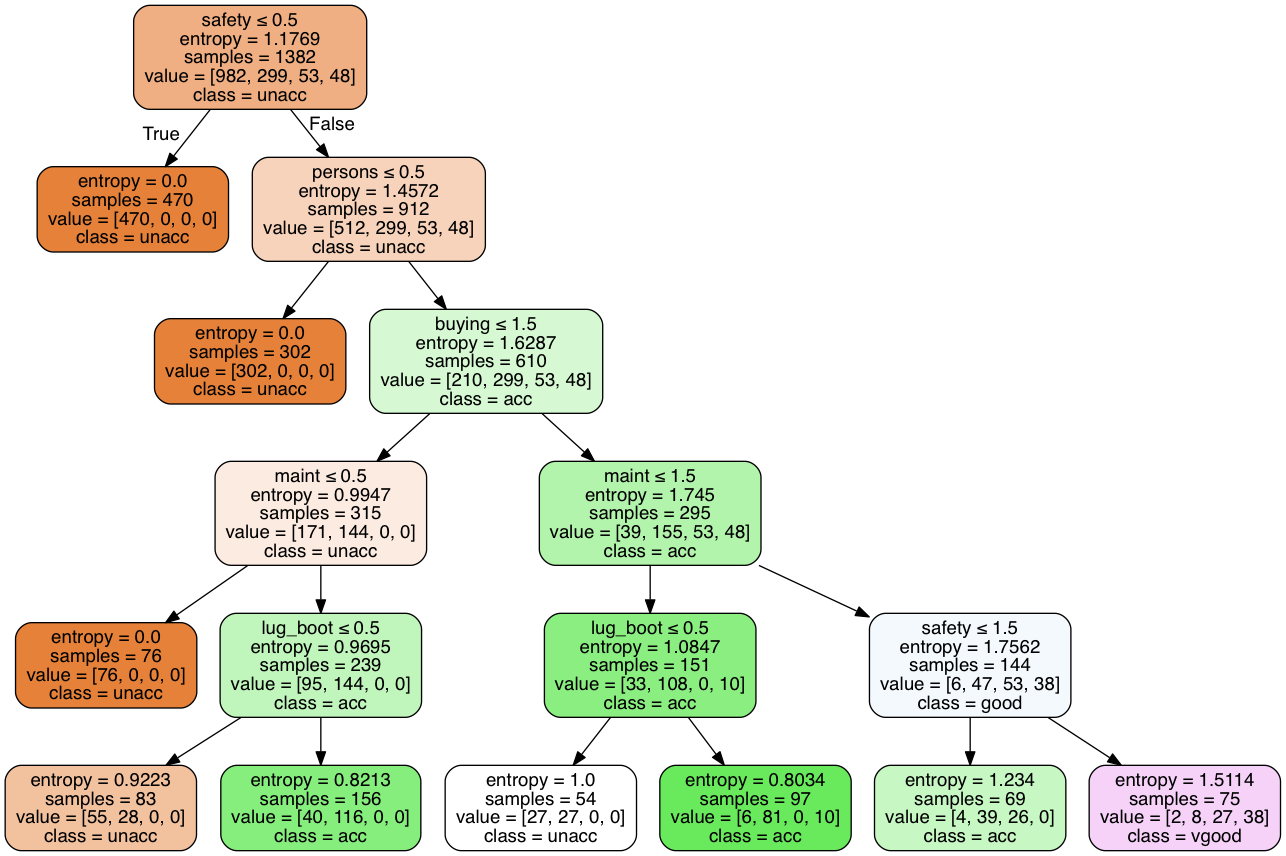

In [231]:
dot_data = tree.export_graphviz(model, out_file=None,
                        feature_names=data.attr_names[:-1], 
                        class_names=["unacc", "acc", "good", "vgood"],
                         filled=True, rounded=True,  
                         special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_jpeg('cars.jpg')
Image(graph.create_png())  

In [232]:
model.feature_importances_

array([ 0.15156317,  0.16466319,  0.        ,  0.30737767,  0.05395686,
        0.32243912])

In [539]:
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import time
from tabulate import tabulate

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [600]:
def testModel(model, data, labels, num_tests=3):
    ''' Tests a model for comparison by averaging results.
    Args:
      model: sklearn model
      data : dataset
      lables : lables
      num_tests : number of times to average
    
    Returns:
      avg_score : the average model score
      avg_time : the average training time
    '''
    
    scores = []
    train_times = []
    for _ in range(num_tests):
        x_train, x_test, y_train, y_test = train_test_split(data, labels, train_size=.7)
        start = time.time()
        model.fit(x_train, y_train)
        stop = time.time()
        train_times.append(stop - start)
        scores.append(model.score(x_test, y_test))
        
    return np.mean(scores), np.mean(train_times)


model_list = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    xgb.XGBClassifier()
]

model_names = [
    'Descision Tree',
    'Random Forrests',
    'Gradient Boosting',
    'XGBoost'
]

score_list = []
time_list = []

for model in model_list:
    score, train_time = testModel(model, data.data, data.labels)
    score_list.append(score)
    time_list.append(train_time)
    
print(tabulate([[x,y,z] for x,y,z in zip(model_names, score_list, time_list)],
               headers=['Model', 'Accuracy', 'Time']))

Model                Accuracy         Time
-----------------  ----------  -----------
Descision Tree       0.925659  0.000589689
Random Forrests      0.959233  0.0370127
Gradient Boosting    0.956835  0.0511634
XGBoost              0.956835  0.066401


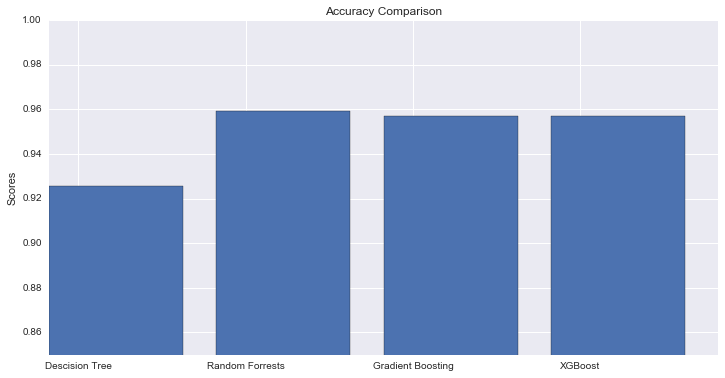

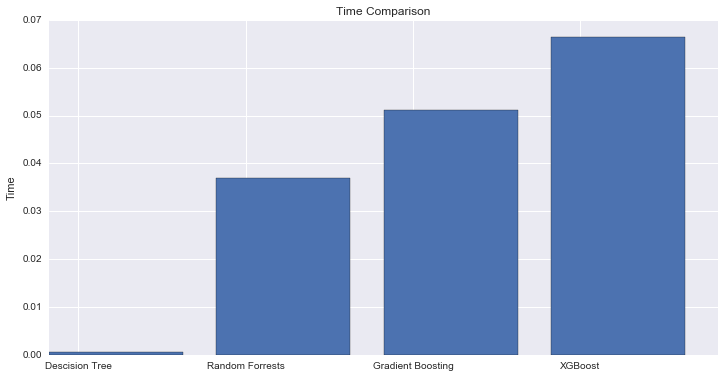

In [601]:
# Plot Results
f, ax = plt.subplots(figsize=(12,6), dpi=500)
ind = np.arange(len(score_list))
bar_1 = ax.bar(ind, score_list)
ax.set_ylabel('Scores')
ax.set_title('Accuracy Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=0)
plt.ylim(.85,1)
plt.savefig('acc-compare-voting.png')
plt.show()

f, ax = plt.subplots(figsize=(12,6), dpi=500)
ind = np.arange(len(time_list))
bar_1 = ax.bar(ind, time_list)
ax.set_ylabel('Time')
ax.set_title('Time Comparison')
ax.set_xticks(ind + .35 / 2)
ax.set_xticklabels(model_names, rotation=0)
plt.savefig('time-compare-voting.png')
plt.show()

In [552]:
print data

@RELATION vote2@ATTRIBUTE handicapped-infants
 {'n', 'y'}
@ATTRIBUTE water-project-cost-sharing
 {'n', 'y'}
@ATTRIBUTE adoption-of-the-budget-resolution
 {'n', 'y'}
@ATTRIBUTE physician-fee-freeze
 {'n', 'y'}
@ATTRIBUTE el-salvador-aid
 {'n', 'y'}
@ATTRIBUTE religious-groups-in-schools
 {'n', 'y'}
@ATTRIBUTE anti-satellite-test-ban
 {'n', 'y'}
@ATTRIBUTE aid-to-nicaraguan-contras
 {'n', 'y'}
@ATTRIBUTE mx-missile
 {'n', 'y'}
@ATTRIBUTE immigration
 {'n', 'y'}
@ATTRIBUTE synfuels-corporation-cutback
 {'n', 'y'}
@ATTRIBUTE education-spending
 {'n', 'y'}
@ATTRIBUTE superfund-right-to-sue
 {'n', 'y'}
@ATTRIBUTE crime
 {'n', 'y'}
@ATTRIBUTE duty-free-exports
 {'n', 'y'}
@ATTRIBUTE export-administration-act-south-africa
 {'n', 'y'}
@ATTRIBUTE Class
 {'democrat', 'republican'}
@DATA
[[ 0.  1.  0. ...,  1.  0.  1.]
 [ 1.  1.  1. ...,  1.  0.  1.]
 [ 0.  1.  0. ...,  1.  0.  1.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  1.]
 [ 1.  0.  0. ...,  1.  0.  1.]
 [ 0.  0.  0. ...,  1.  0.  1.]]


1.  (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits.  Otherwise, even with approaches like pruning below, the SS# type of overfit could still hurt us.) It is a good idea to use a simple data set (like the lenses data), which you can check by hand, to test your algorithm to make sure that it is working correctly. You should be able to get about 68% (61%-82%) predictive accuracy on lenses.

2. (15%) You will use your ID3 algorithm to induce decision trees for the cars data set and the voting data set.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  Note that with a full tree you will often get 100% accuracy on the training set. (Why would you and in what cases would you not?  This question is for our discussion, and should also be answered in your report.)  Note that you will need to support unknown attributes in the voting data set.  Use 10-fold CV on each data set to predict how well the models will do on novel data.  Report the training and test classification accuracy for each fold and then average the test accuracies to get your prediction.  Create a table summarizing these accuracy results, and discuss what you observed.  As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

3. (10%) For each of the two problems, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what rules it has discovered to try to solve each task).  If the tree is large you can just discuss a few of the more shallow attributes combinations and the most important decisions made high in the tree.

4.  (5%) How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

5.  (15%) Implement reduced error pruning to help avoid overfitting.  You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy.  Create a table comparing the original trees created with no overfit avoidance in item 2 above and the trees you create with pruning.  This table should compare a) the # of nodes (including leaf nodes) and tree depth of the final decision trees and b) the generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).

6.  (15%) Do an experiment of your own regarding decision trees.  You can be as creative as you would like on this.  Experiments could include such things as modifying the algorithm, modifying the measure of best attribute, comparing information gain and gain ratio, supporting real valued attributes, comparing different stopping criteria and/or pruning approaches, etc.  Be creative!